In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sample_dir = "/content/drive/MyDrive/EDR/"

# Using OpenCV

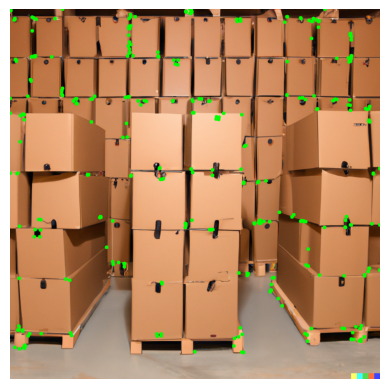

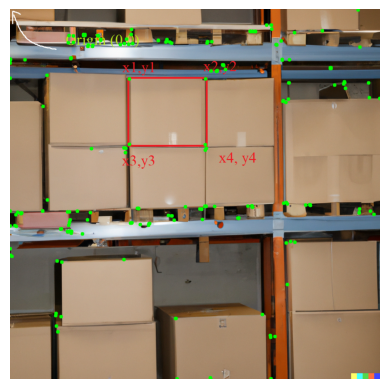

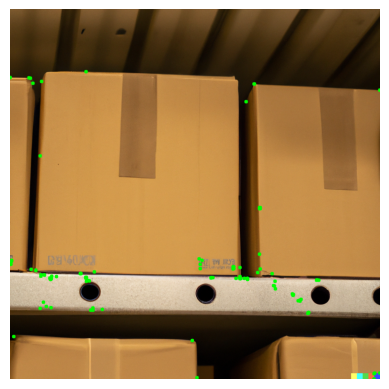

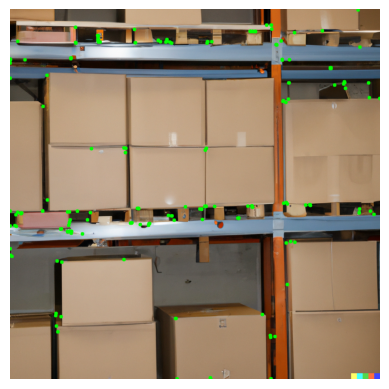

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def get_corner_from_canny_edges(img_name):
  # Load image from URL or upload it to Colab
  # Make sure to replace 'box_image.jpg' with the path to your image
  image = cv2.imread(sample_dir + img_name)

  # Convert the image to RGB (matplotlib uses RGB format)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Preprocess image if necessary (e.g., convert to grayscale)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Define threshold values
  threshold1 = 50
  threshold2 = 150

  # Detect edges
  edges = cv2.Canny(image, threshold1, threshold2)

  # Find contours
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Filter contours
  # (You might need to implement filtering based on your specific criteria)

  # Approximate contours to polygons
  for contour in contours:
      epsilon = 0.04 * cv2.arcLength(contour, True)
      approx = cv2.approxPolyDP(contour, epsilon, True)
      if len(approx) == 4:  # Check if it's a quadrilateral (i.e., a box)
          box_corners = approx.reshape(-1, 2)
          # print("Box corners:", box_corners)

          # Annotate image with coordinates
          for (x, y) in box_corners:
              cv2.circle(image_rgb, (x, y), 5, (0, 255, 0), -1)
              # cv2.putText(image_rgb, f'({x}, {y})', (x - 50, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

  # Display annotated image
  plt.imshow(image_rgb)
  plt.axis('off')
  plt.show()


for img in os.listdir(sample_dir):
    if img.endswith(".png"):
        get_corner_from_canny_edges(img)

# Using Deep Learning Methods (DeepLabV3)

 ![DeepLabV3 Architecture](https://assets-global.website-files.com/645cec60ffb18d5ebb37da4b/656f49611e75aa3aefadff9a_overview.jpg)

DeeplabV3 pytorch docs : https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

Convert images to JPG (to remove the last channel, alpha)

In [ ]:
from PIL import Image
import os

def convert_to_jpg(img_path):
    # Open the image
    img = Image.open(img_path)

    # Convert to RGB (if the image is in RGBA format)
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Get the file name without extension
    file_name, _ = os.path.splitext(img_path)

    # Save as JPG format
    img.save(file_name + '.jpg', quality=95)  # You can adjust the quality as needed

# Iterate through the images in the directory
for img in os.listdir(sample_dir):
    if img.endswith(".png"):
        img_path = os.path.join(sample_dir, img)
        convert_to_jpg(img_path)


In [ ]:
os.listdir(sample_dir)

['img3.png',
 'img1_annotated.png',
 'img2.png',
 'img1.png',
 'img3.jpg',
 'img1_annotated.jpg',
 'img1.jpg',
 'img2.jpg',
 'biker_images',
 '.ipynb_checkpoints',
 'EDR_Corner_detection.ipynb']

Try object detection first,
Search for Instance Segmentation, Semantic Segmentation,  

MMLAB (model zoo)

In [ ]:
import torch
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# Load pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)


# Set the model to evaluation mode
model.eval()

# Define a transformation to preprocess the input image
transform = T.Compose([
    T.Resize((256, 256)),  # Resize the image to the required input size of the model
    T.ToTensor(),          # Convert PIL image to PyTorch tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 102MB/s] 


In [ ]:
# Load and preprocess the input image
image = Image.open(sample_dir + "img1.jpg" )
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # 'out' is the key for the segmentation mask

# Convert the output tensor to a numpy array
segmentation_mask = output.argmax(0).cpu().numpy()

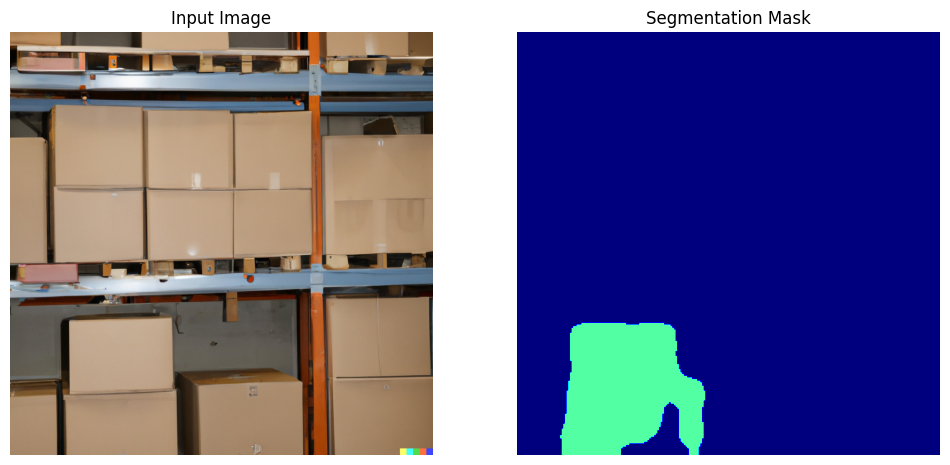

In [ ]:
# Visualize the input image and segmentation mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display input image
axes[0].imshow(image)
axes[0].set_title('Input Image')
axes[0].axis('off')

# Display segmentation mask
axes[1].imshow(segmentation_mask, cmap='jet', vmin=0, vmax=20)  # Adjust vmin and vmax according to your classes
axes[1].set_title('Segmentation Mask')
axes[1].axis('off')

plt.show()


In [ ]:
def get_segments_from_deeplabv3(sample_dir, img_name):
# Load and preprocess the input image
  image = Image.open(sample_dir + img_name )

  input_tensor = transform(image).unsqueeze(0)  # Add batch dimension


  # Perform inference
  with torch.no_grad():
      output = model(input_tensor)['out'][0]  # 'out' is the key for the segmentation mask

  # Convert the output tensor to a numpy array
  segmentation_mask = output.argmax(0).cpu().numpy()

  # Visualize the input image and segmentation mask
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Display input image
  axes[0].imshow(image)
  axes[0].set_title('Input Image')
  axes[0].axis('off')

  # Display segmentation mask
  axes[1].imshow(segmentation_mask, cmap='jet', vmin=0, vmax=20)  # Adjust vmin and vmax according to your classes
  axes[1].set_title('Segmentation Mask')
  axes[1].axis('off')

  plt.show()

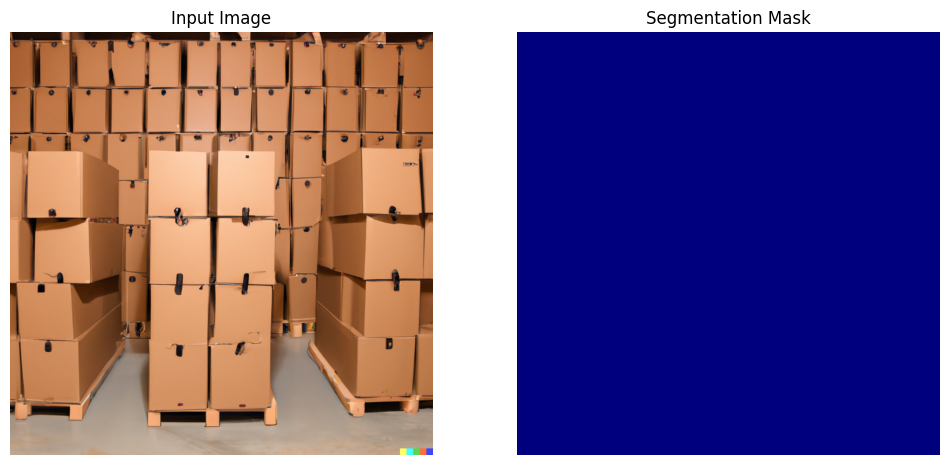

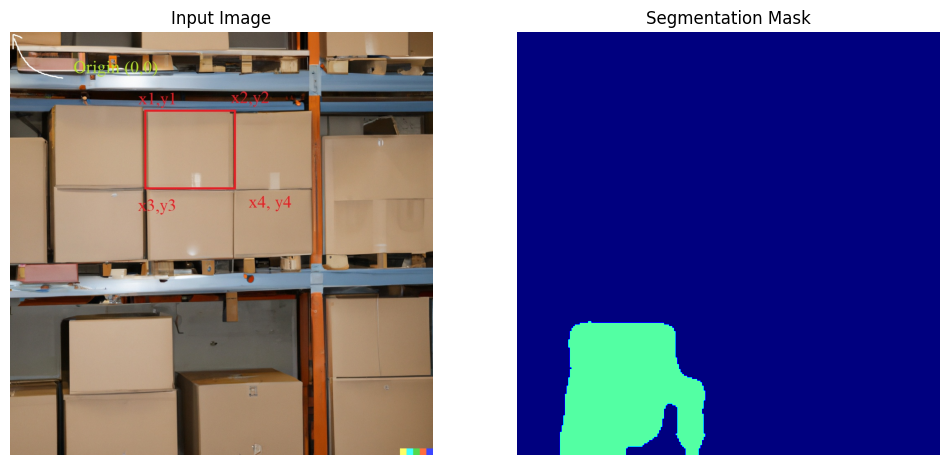

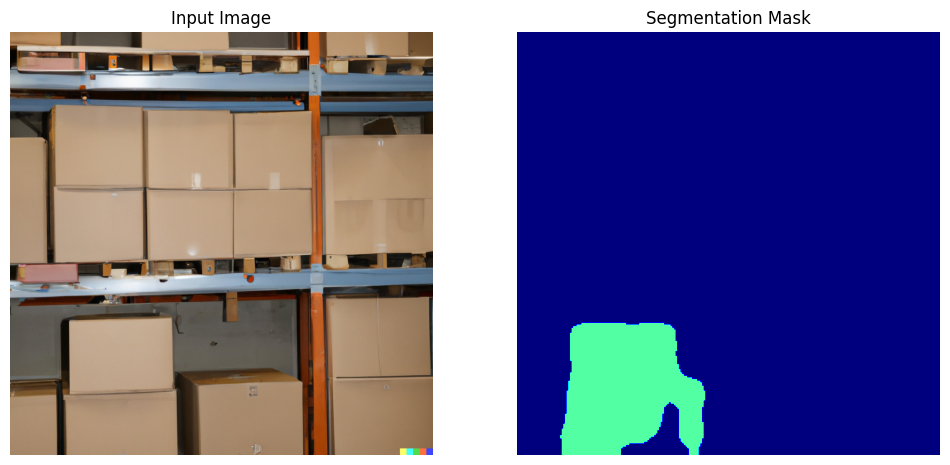

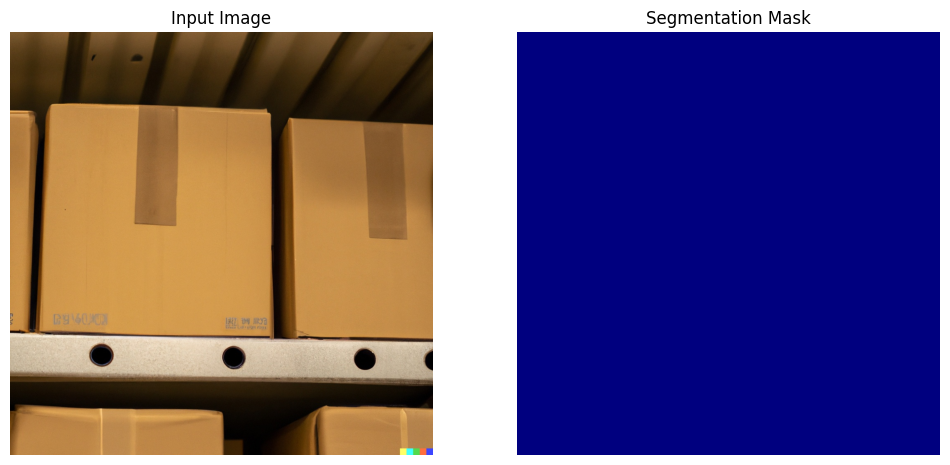

In [ ]:
for img in os.listdir(sample_dir):
    if img.endswith(".jpg"):
        get_segments_from_deeplabv3(sample_dir, img)

### DeepLabV3 on an image from Cityscape

In [ ]:
biker_images_path = "/content/drive/MyDrive/EDR/biker_images/biker_images/"

In [ ]:
# prompt: upload images from the terminal

!cp -r /content/biker_images /content/drive/MyDrive/EDR/biker_images

cp: cannot stat '/content/biker_images': No such file or directory


In [ ]:
os.listdir(biker_images_path)

['biker2.jpg', 'biker1 (1).jpg', 'horses.jpg']

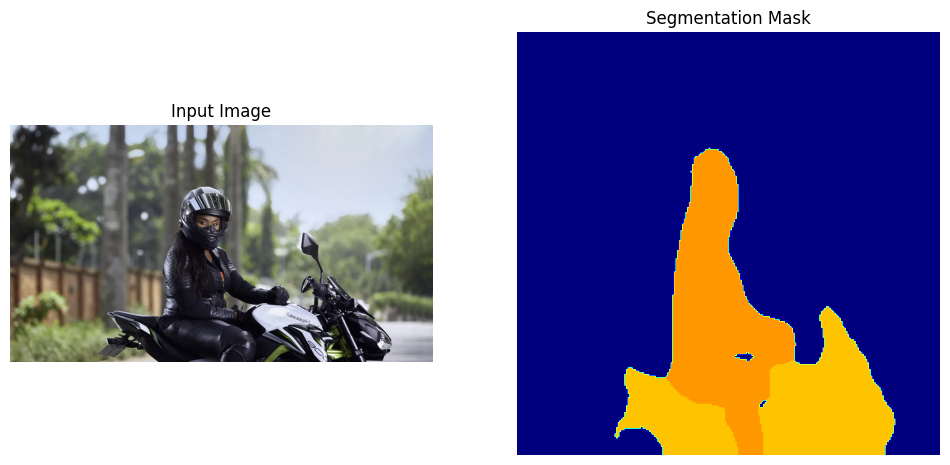

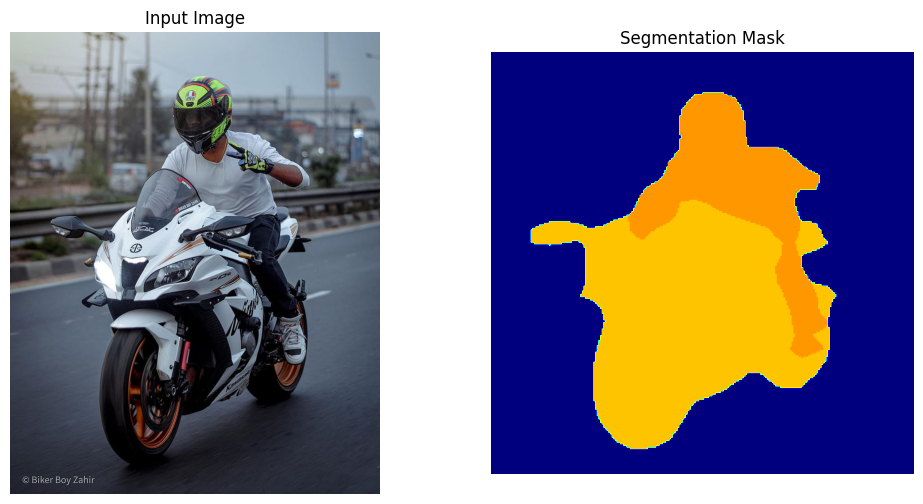

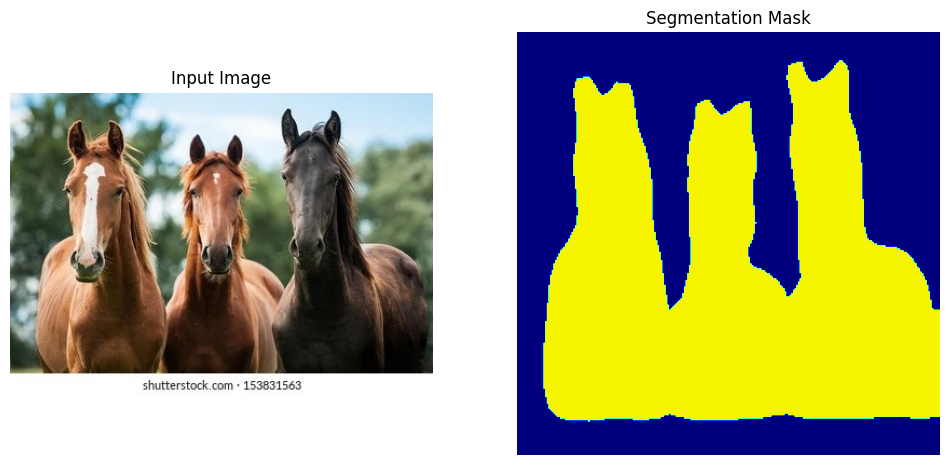

In [ ]:
for img in os.listdir(biker_images_path):
    if img.endswith(".jpg"):
        get_segments_from_deeplabv3(biker_images_path,img)

In [ ]:
break

SyntaxError: 'break' outside loop (<ipython-input-16-6aaf1f276005>, line 1)

# DeeplabV3 Ikomia (wrapper)

In [ ]:
!pip install ikomia

In [ ]:
from ikomia.dataprocess.workflow import Workflow
from ikomia.utils.displayIO import display


# Init your workflow
wf = Workflow()

# Add the Deeplab algorithm
deeplab = wf.add_task(name="infer_detectron2_deeplabv3plus", auto_connect=True)
deeplab.set_parameters({"dataset": "Cityscapes"})

# Run on your image
wf.run_on(url=sample_dir + "img1.jpg")

# Inspect your results
display(deeplab.get_image_with_mask())